# Imports & Functions

In [229]:
from datetime import datetime, time
import pandas as pd
# from sodapy import Socrata
import numpy as np 
import ast
import json
import pandasql
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas import Series
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [230]:
morningStart = time(6, 0, 0)
morningEnd = time(12,0,0)
afternoonStart = time(12,0,1)
afternoonEnd = time(18,30,0)
nightStart = time(18,31,0)
nightEnd = time(23,59,59)
midnightStart = time(0,0,0)
midnightEnd = time(5,59,0)
springStart = 3
springEnd = 5
summerStart = 6
summerEnd = 8
fallStart = 9
fallEnd = 11
winterStart = 12
winterEnd = 2 

# Time of Day Function
def timeOfDayApplier(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
    
    if morningStart <= DatetimeVersion.time() <= morningEnd:
        return "Morning"
    elif afternoonStart <= DatetimeVersion.time() <= afternoonEnd:
        return "Afternoon/Evening"
    elif nightStart <= DatetimeVersion.time() <= nightEnd:
        return "Night"
    elif midnightStart <= DatetimeVersion.time() <= midnightEnd:
        return "Midnight"


# Time of Day Function
def seasonOfYear(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.month in [12,1,2]:
        return "Winter"   
    elif springStart <= DatetimeVersion.month <= springEnd:
        return "Spring"
    elif summerStart <= DatetimeVersion.month <= summerEnd:
        return "Summer"
    elif fallStart <= DatetimeVersion.month <= fallEnd:
        return "Fall"

# Time of Day Function
def dayOfWeek(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.weekday() in [0,1,2,3,4]:
        return "Weekday"   
    else:
        return "Weekend"

# Data Preprocessing

In [231]:
# Connecting police districts to community area names off of community area coddes
CommunityToPoliceDistrict = []
with open('PoliceDistrictToCommunityNamesOutput.txt') as fp:
    for line in fp:
        communityNum, communityName, policeDist  = line.strip().split(":")
        communityName = communityName.strip()
        CommunityToPoliceDistrict.append({"Community_Area": float(communityNum), "Community_Name": communityName,
                                         "Police_District": policeDist})

CommunityPoliceDistrictDF = pd.DataFrame(CommunityToPoliceDistrict)

In [232]:
community_areas = CommunityPoliceDistrictDF['Community_Name'].tolist()
colors = []
for i in range(len(community_areas)):
    colors.append(np.random.rand(3,))
    
dictionary = dict(zip(community_areas, colors))

In [233]:
# Crime data from from the crimes csv with community area names for where the crime occured
CrimeData = pd.read_csv("Crimes2001_2020.csv",
                       dtype={'ID': int, 'Case Number' : str, 'Date' : str, 'Block' : str, 
                             'IUCR' : str, 'Primary Type' : str, 'Description' : str, 
                             'Location Description' : str, 'Arrest' : str, 'Domestic' : str, 'Beat' : str, 
                             'District' : float, 'Ward' : float, 'Community Area' : float, 'FBI Code' : str, 
                              'X Coordinate' : str, 'Y Coordinate' : str, 'Year' : int,'Updated On' : str,
                             'Latitude' : str, 'Longitude' : str, 'Location' : str}, )

CrimeData.rename(columns = {'Community Area':'Community_Area'}, inplace = True)
CrimeData = CrimeData.drop(['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'], axis = 1)
SampledCrimeData = CrimeData
SampledCrimeData = SampledCrimeData.join(CommunityPoliceDistrictDF.set_index('Community_Area'), on='Community_Area')

In [234]:
# Used to Extract the data from the Socio Economic CSV File 
# To train our program what specific communities are better or worse off than average
# We can use .describe() to find the benchmark levels of poverty per community. Compare community to the average and give weightage 
columns = [
'Community_Area',
'community_area_name', 
'%_housing_crowded', 
'%_households_below_poverty', 
'%_age16_unemployed',
'%_age25_nohighschool',
'%_not_working_age',
'per_capita_income',
'hardship_index']
SocioeconomicData = pd.read_csv("SocioeconomicData.csv")
SocioeconomicData.columns = columns
SampledSocioeconomicCrimeData = SampledCrimeData.join(SocioeconomicData.set_index('Community_Area'), on='Community_Area')

In [235]:
# Adding census data to the sampled socioeconomic crime data df
CensusData = pd.read_csv("census_data.csv", sep ='\t')
#CensusData = CensusData[CensusData.columns[range(67)]]
CensusData = CensusData.rename(columns={'Average Household Size' : "Average_Household_Size",
                                       'Vacant Housing Units' : 'Vacant_Households'})

SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.merge(CensusData, on='Community_Area', how='left')
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(
    ['Arrest', 'Domestic', 'FBI Code', 'IUCR', 'Beat', 'Ward',
    'Case Number', 'Block', 'Primary Type', 'Description','Location Description', 'District', 'Year',
       'Updated On', 'community_area_name', 'Police_District','Not Hispanic or Latino, American Indian and Alaska Native alone','Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone', 
     'Not Hispanic or Latino, Some Other Race alone','Not Hispanic or Latino, Two or More Races'], axis = 1)

SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.dropna()
SampledSocioeconomicCrimeData.rename(columns={'Not Hispanic or Latino, White alone' : 'Num_White',
       'Not Hispanic or Latino, Black or African American alone' : "Num_African_American",
       'Not Hispanic or Latino, Asian alone' : "Num_Asian",'Hispanic or Latino' : "Num_Hispanic"}, inplace = True)


In [236]:
# Add time of day to the crime data and socioeconomic data
SampledSocioeconomicCrimeData['TimeOfDay'] = SampledSocioeconomicCrimeData['Date'].map(timeOfDayApplier)
SampledSocioeconomicCrimeData['Season'] = SampledSocioeconomicCrimeData['Date'].map(seasonOfYear)
SampledSocioeconomicCrimeData['Weekday_Weekend'] = SampledSocioeconomicCrimeData['Date'].map(dayOfWeek)

SampledCrimeData['TimeOfDay'] = SampledCrimeData['Date'].map(timeOfDayApplier)
SampledCrimeData['Season'] = SampledCrimeData['Date'].map(seasonOfYear)
SampledCrimeData['Weekday/Weekend'] = SampledCrimeData['Date'].map(dayOfWeek)

In [237]:
# Putting auxiliary data in bins
DiscCutSocioeconomicCrimeData = SampledSocioeconomicCrimeData.copy()
DiscCutSocioeconomicCrimeData.columns

# Using equal bin width
c = ['%_housing_crowded','%_households_below_poverty', '%_age16_unemployed',
       '%_age25_nohighschool', '%_not_working_age', 'per_capita_income',
       'hardship_index', 'Total Population', 'Num_White',
       'Num_African_American', 'Num_Asian', 'Num_Hispanic',
       'Male: Under 5 years old', 'Male: 5 to 9 years', 'Male: 10 to 14 years',
       'Male: 15 to 17 years', 'Male: 18 and 19 years', 'Male: 20 years',
       'Male: 21 years', 'Male: 22 to 24 years', 'Male: 25 to 29 years',
       'Male: 30 to 34 years', 'Male: 35 to 39 years', 'Male: 40 to 44 years',
       'Male: 45 to 49 years', 'Male: 50 to 54 years', 'Male: 55 to 59 years',
       'Male: 60 and 61 years', 'Male: 62 to 64 years',
       'Male: 65 and 66 years', 'Male: 67 to 69 years', 'Male: 70 to 74 years',
       'Male: 75 to 79 years', 'Male: 80 to 84 years',
       'Male: 85 years and over', 'Female: Under 5 years old',
       'Female: 5 to 9 years', 'Female: 10 to 14 years',
       'Female: 15 to 17 years', 'Female: 18 and 19 years', 'Female: 20 years',
       'Female: 21 years', 'Female: 22 to 24 years', 'Female: 25 to 29 years',
       'Female: 30 to 34 years', 'Female: 35 to 39 years',
       'Female: 40 to 44 years', 'Female: 45 to 49 years',
       'Female: 50 to 54 years', 'Female: 55 to 59 years',
       'Female: 60 and 61 years', 'Female: 62 to 64 years',
       'Female: 65 and 66 years', 'Female: 67 to 69 years',
       'Female: 70 to 74 years', 'Female: 75 to 79 years',
       'Female: 80 to 84 years', 'Female: 85 years and over', 'Median Age',
       'Total Households', 'Average_Household_Size', 'Total Housing Units',
       'Occupied Housing Units', 'Vacant_Households',
       'Occupied Housing Units.1', 'Owned with a mortgage or a loan',
       'Owned free and clear', 'Renter occupied', 'Male_Female_Ratio ']
for col in DiscCutSocioeconomicCrimeData[c]:
    DiscCutSocioeconomicCrimeData[col] = pd.cut(DiscCutSocioeconomicCrimeData[col],bins=3, labels=['low', 'med', 'high'])
DiscCutSocioeconomicCrimeData.head()

,ID,Date,Community_Area,Community_Name_x,%_housing_crowded,%_households_below_poverty,%_age16_unemployed,%_age25_nohighschool,%_not_working_age,per_capita_income,...,Occupied Housing Units,Vacant_Households,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied,Male_Female_Ratio,TimeOfDay,Season,Weekday_Weekend
0,11034701,01/01/2001 11:00:00 AM,45.0,AVALON PARK,low,low,med,low,high,low,...,low,low,low,low,low,low,low,Morning,Winter,Weekday
1,11227287,10/08/2017 03:00:00 AM,73.0,WASHINGTON HEIGHTS,low,low,med,low,high,low,...,low,low,low,low,low,low,low,Midnight,Fall,Weekend
2,11227583,03/28/2017 02:00:00 PM,70.0,ASHBURN,low,low,low,low,med,low,...,low,low,low,med,low,low,med,Afternoon/Evening,Spring,Weekday
3,11227293,09/09/2017 08:17:00 PM,42.0,WOODLAWN,low,med,med,low,med,low,...,low,low,low,low,low,low,low,Night,Fall,Weekend
4,11227634,08/26/2017 10:00:00 AM,32.0,LOOP,low,low,low,low,low,high,...,low,med,low,low,low,low,med,Morning,Summer,Weekend


In [238]:
# Prepare data for pandasql statement
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(['Community_Name_y'], axis = 1)
SampledSocioeconomicCrimeData.rename(columns = {'Community_Name_x':'Community_Name', '%_housing_crowded':'percent_housing_crowded',
                                   '%_households_below_poverty': 'percent_households_below_poverty',
                                   '%_age16_unemployed' : 'percent_age16_unemployed',
                                   '%_age25_nohighschool' : 'percent_age25_nohighschool'}, inplace = True)

In [239]:
query = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,Community_Area
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    ,TimeOfDay
    ,Season
    ,Weekday_Weekend
    ,COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name, TimeOfDay, Season, Weekday_Weekend
)
SELECT 
    cr.Community_Name
    ,cr.Community_Area
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.TimeOfDay
    ,cr.Season
    ,cr.Weekday_Weekend
    ,cr.crimes Num_Crimes
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""

query2 = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    , COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name
)
SELECT 
    cr.Community_Name
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.crimes Num_Crimes
    
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""


AggregatedDataframe = pandasql.sqldf(query, globals())
DataframeToVisualize = pandasql.sqldf(query2, globals())

print("Sample aggregated data: \n")
print(AggregatedDataframe[(AggregatedDataframe['Community_Name'] == "AUSTIN") & (AggregatedDataframe['TimeOfDay'] == "Midnight")
                         & (AggregatedDataframe['Season'] == "Winter")].head())
print("# CRIMES TOTAL: ",sum(AggregatedDataframe.Num_Crimes))

Sample aggregated data: 

    Community_Name  Community_Area  percent_age16_unemployed  \
0           AUSTIN            25.0                      22.6   
574         AUSTIN            25.0                      22.6   

     percent_households_below_poverty  percent_age25_nohighschool  \
0                                28.6                        24.4   
574                              28.6                        24.4   

     per_capita_income  hardship_index  Average_Household_Size  \
0              15957.0            73.0                    2.96   
574            15957.0            73.0                    2.96   

     Vacant_Households  Num_Asian  Num_African_American  Num_White TimeOfDay  \
0               5422.0      573.0               83837.0     4364.0  Midnight   
574             5422.0      573.0               83837.0     4364.0  Midnight   

     Season Weekday_Weekend  Num_Crimes  
0    Winter         Weekday          33  
574  Winter         Weekend           4  
# CRIME

In [240]:
import seaborn as sns
%matplotlib inline

corrmat = AggregatedDataframe.corr()
fig = plt.figure(figsize = (8, 8))
sns.set(font_scale=0.8)
sns.heatmap(corrmat, vmax = 0.8)
plt.yticks(rotation=0, fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.show()

ImportError: cannot import name 'sort_df'

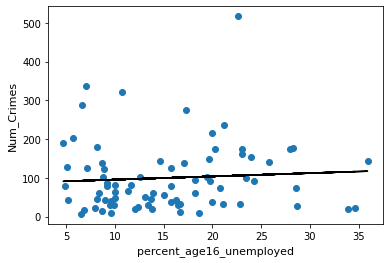

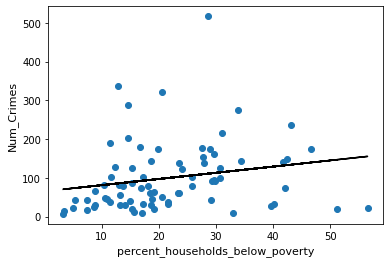

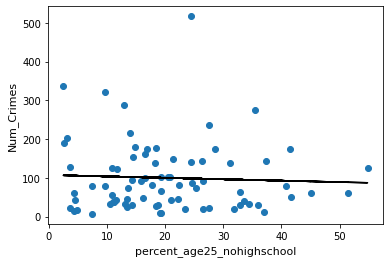

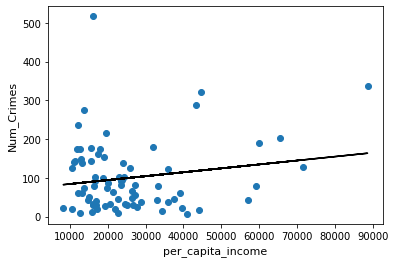

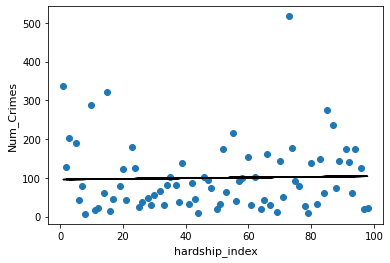

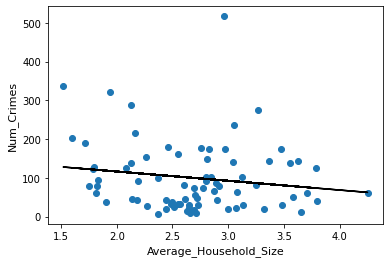

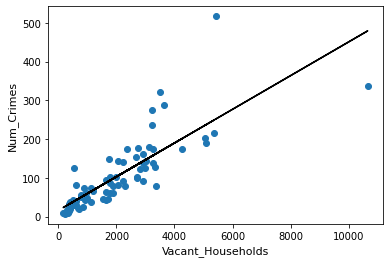

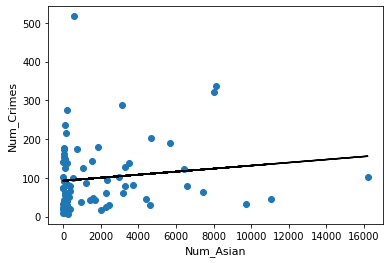

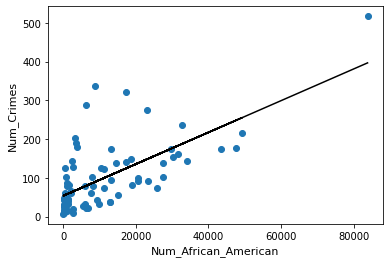

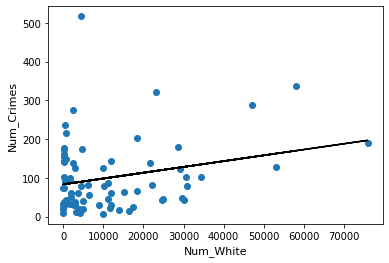

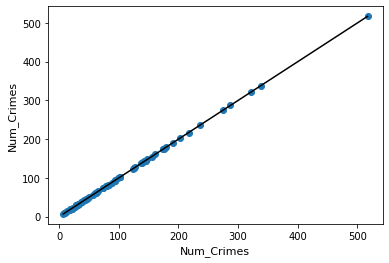

In [241]:
predictorColumns = DataframeToVisualize.columns
%matplotlib inline

for column in predictorColumns: 
    if column not in ['TimeOfDay', 'Season', 'Community_Name']:
        plt.scatter(x=DataframeToVisualize[column], y=DataframeToVisualize['Num_Crimes'])
        m, b = np.polyfit(DataframeToVisualize[column],DataframeToVisualize['Num_Crimes'], 1)
        plt.plot(DataframeToVisualize[column], m*DataframeToVisualize[column] + b,color='black')
        plt.xlabel(column, fontsize=11)
        plt.ylabel("Num_Crimes", fontsize=11)
        plt.show()

In [242]:
# For finding the most common type of crime
PrimaryCrimeTypes = SampledCrimeData['Primary Type'].unique()
PrimaryCrimeTypeCounts = pd.DataFrame()
for c in PrimaryCrimeTypes:
    df = SampledCrimeData[SampledCrimeData['Primary Type']==c]
    PrimaryCrimeTypeCounts[c] = df['Community_Name'].value_counts().sort_index()

# Contains counts of each primary type of crime for each community area
PrimaryCrimeTypeCounts.fillna(0) 
print("Crime Counts by Type of Crime by Community Area")
PrimaryCrimeTypeCounts

Crime Counts by Type of Crime by Community Area


,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,BURGLARY,THEFT,OFFENSE INVOLVING CHILDREN,CRIMINAL DAMAGE,OTHER OFFENSE,NARCOTICS,SEX OFFENSE,BATTERY,...,NON-CRIMINAL,PUBLIC PEACE VIOLATION,LIQUOR LAW VIOLATION,PROSTITUTION,INTIMIDATION,ARSON,INTERFERENCE WITH PUBLIC OFFICER,GAMBLING,STALKING,KIDNAPPING
ALBANY PARK,11,NaN,1.0,18,3.0,4.0,2.0,3.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARCHER HEIGHTS,4,NaN,NaN,10,4.0,1.0,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASHBURN,21,1.0,7.0,18,5.0,7.0,3.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
AUBURN GRESHAM,39,5.0,5.0,41,9.0,9.0,7.0,21.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
AUSTIN,81,10.0,8.0,72,15.0,14.0,26.0,138.0,11.0,50.0,...,1.0,2.0,NaN,15.0,NaN,NaN,1.0,2.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST LAWN,6,2.0,NaN,12,5.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEST PULLMAN,20,3.0,NaN,18,9.0,8.0,5.0,12.0,4.0,9.0,...,NaN,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN
WEST RIDGE,23,1.0,4.0,29,2.0,7.0,8.0,2.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
WEST TOWN,34,1.0,7.0,85,6.0,24.0,10.0,20.0,4.0,21.0,...,NaN,2.0,2.0,9.0,NaN,NaN,NaN,NaN,1.0,NaN


In [243]:
# Contains the most common type of crime for each community area
MostCommonPrimaryCrimeType = pd.DataFrame(PrimaryCrimeTypeCounts.idxmax(axis=1))
MostCommonPrimaryCrimeType.columns = ['Primary Type']
print(MostCommonPrimaryCrimeType)

                      Primary Type
ALBANY PARK                  THEFT
ARCHER HEIGHTS               THEFT
ASHBURN         DECEPTIVE PRACTICE
AUBURN GRESHAM               THEFT
AUSTIN                   NARCOTICS
...                            ...
WEST LAWN                    THEFT
WEST PULLMAN    DECEPTIVE PRACTICE
WEST RIDGE                   THEFT
WEST TOWN                    THEFT
WOODLAWN        DECEPTIVE PRACTICE

[74 rows x 1 columns]


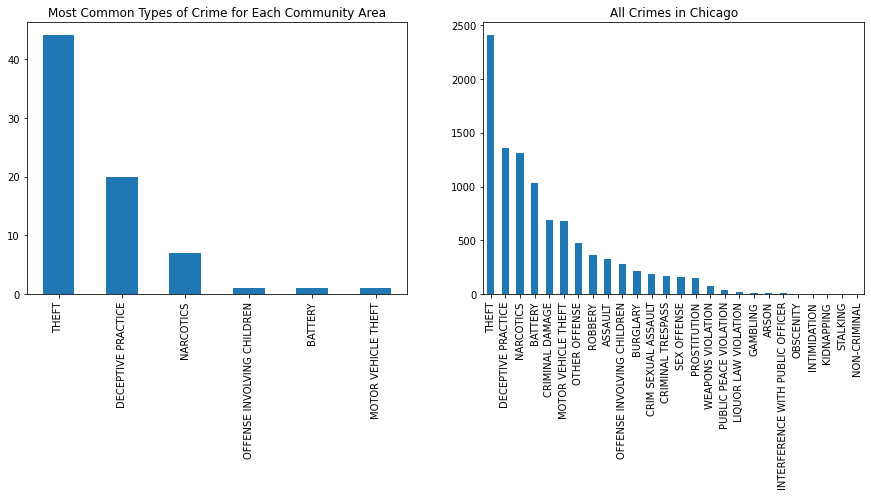

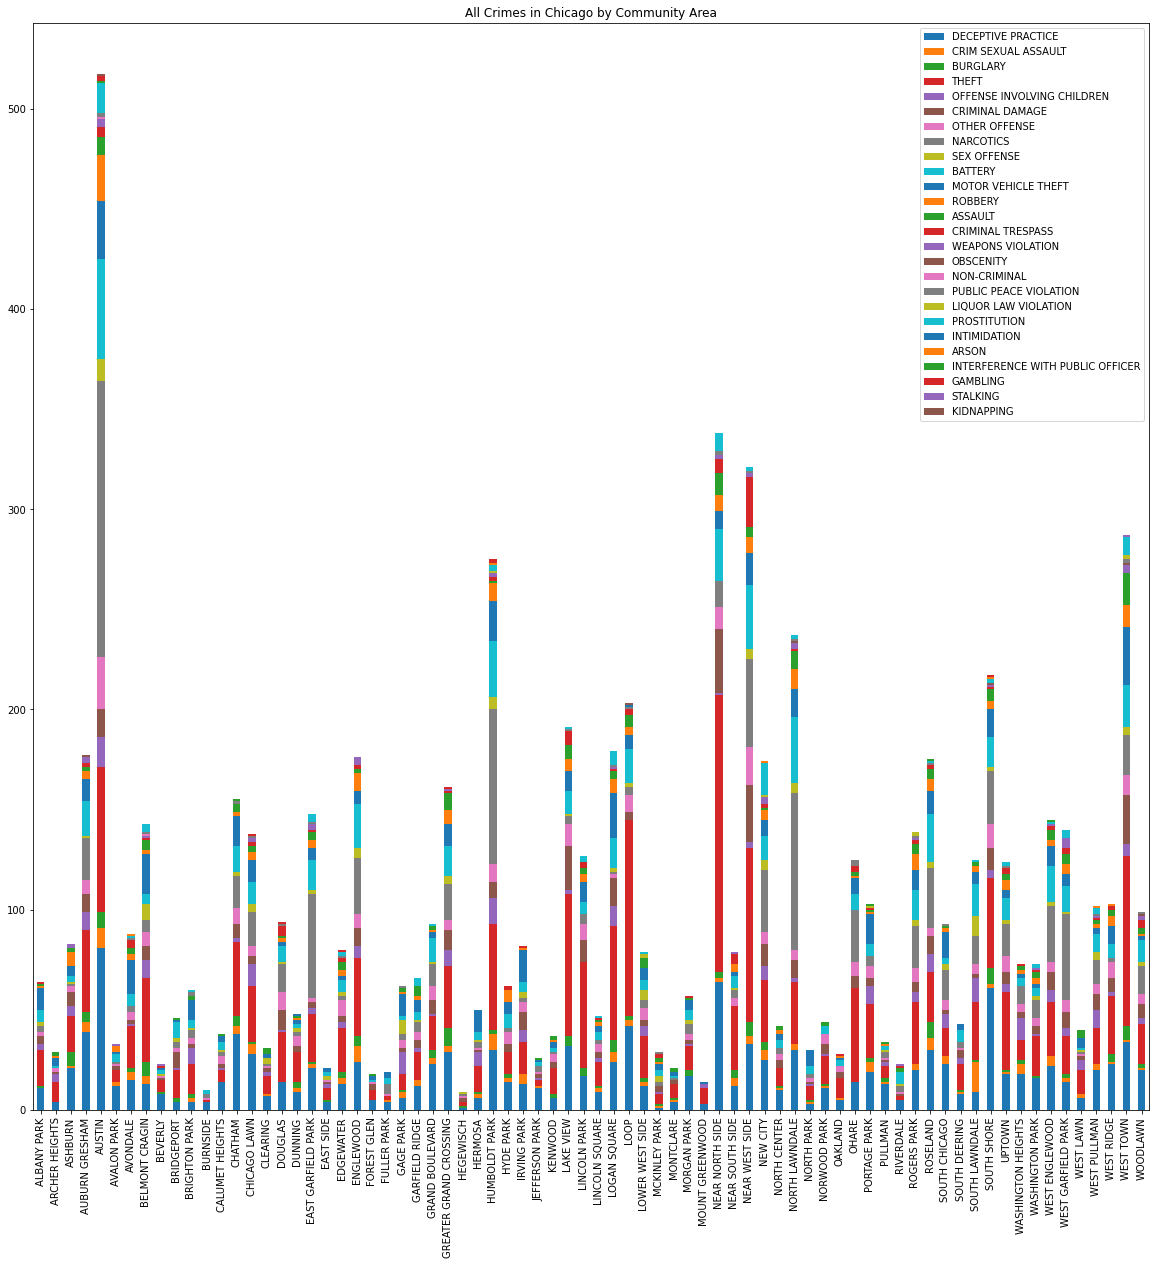

In [244]:
plt.subplot(1, 2, 1)

# Sums the most common type of crime for all community areas
TopPrimaryCrimeTypeCounts = MostCommonPrimaryCrimeType['Primary Type'].value_counts()
TopPrimaryCrimeTypeCounts.plot(kind='bar', title = 'Most Common Types of Crime for Each Community Area', figsize=(15,5))

plt.subplot(1, 2, 2)

# Sum of all of the crimes in Chicago
SampledCrimeData['Primary Type'].value_counts().plot(kind='bar', title = 'All Crimes in Chicago', figsize=(15,5))
plt.show()


PrimaryCrimeTypeCounts.plot.bar(stacked=True, figsize=(20,20), title = 'All Crimes in Chicago by Community Area')
plt.show()

In [245]:
# For finding the most common time/season/part of week for crimes by primary crime type

# By time
MostCommonCrimeTimeCounts = pd.DataFrame()
CrimeTimes = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeTimeCounts.fillna(0) 
MostCommonCrimeTime = pd.DataFrame(MostCommonCrimeTimeCounts.idxmax(axis=1))
MostCommonCrimeTime.columns = ['TimeOfDay']
print(MostCommonCrimeTime)
    
# By Season
MostCommonCrimeSeasonCounts = pd.DataFrame()
CrimeSesons = SampledCrimeData['Season'].unique()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeSeasonCounts.fillna(0)
MostCommonCrimeSeason = pd.DataFrame(MostCommonCrimeSeasonCounts.idxmax(axis=1))
MostCommonCrimeSeason.columns = ['Season']
print(MostCommonCrimeSeason)
    
# By time of week
MostCommonCrimeWeekCounts = pd.DataFrame()
CrimeWeek = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeWeekCounts.fillna(0)
MostCommonCrimeWeek = pd.DataFrame(MostCommonCrimeWeekCounts.idxmax(axis=1))
MostCommonCrimeWeek.columns = ['Weekday/Weekend']
print(MostCommonCrimeTime)

                                    TimeOfDay
ARSON                                Midnight
ASSAULT                     Afternoon/Evening
BATTERY                     Afternoon/Evening
BURGLARY                    Afternoon/Evening
CRIM SEXUAL ASSAULT                  Midnight
CRIMINAL DAMAGE             Afternoon/Evening
CRIMINAL TRESPASS                       Night
DECEPTIVE PRACTICE                    Morning
GAMBLING                    Afternoon/Evening
INTIMIDATION                          Morning
KIDNAPPING                              Night
LIQUOR LAW VIOLATION                    Night
MOTOR VEHICLE THEFT                     Night
NARCOTICS                   Afternoon/Evening
NON-CRIMINAL                          Morning
OBSCENITY                             Morning
OFFENSE INVOLVING CHILDREN           Midnight
OTHER OFFENSE                         Morning
PROSTITUTION                            Night
PUBLIC PEACE VIOLATION                  Night
ROBBERY                           

In [246]:
# For finding the most common time/season/part of week for crimes by community area

# By time
MostCommonCrimeTimeCountsCA = pd.DataFrame()
CrimeTimesCA = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeTimeCountsCA.fillna(0) 
MostCommonCrimeTimeCA = pd.DataFrame(MostCommonCrimeTimeCountsCA.idxmax(axis=1))
MostCommonCrimeTimeCA.columns = ['TimeOfDay']
print(MostCommonCrimeTimeCA)
    
# By Season
MostCommonCrimeSeasonCountsCA = pd.DataFrame()
CrimeSesonsCA = SampledCrimeData['Season'].unique()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeSeasonCountsCA.fillna(0)
MostCommonCrimeSeasonCA = pd.DataFrame(MostCommonCrimeSeasonCountsCA.idxmax(axis=1))
MostCommonCrimeSeasonCA.columns = ['Season']
print(MostCommonCrimeSeasonCA)
    
# By time of week
MostCommonCrimeWeekCountsCA = pd.DataFrame()
CrimeWeekCA = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeWeekCountsCA.fillna(0)
MostCommonCrimeWeekCA = pd.DataFrame(MostCommonCrimeWeekCountsCA.idxmax(axis=1))
MostCommonCrimeWeekCA.columns = ['Weekday/Weekend']
print(MostCommonCrimeTimeCA)

                        TimeOfDay
ALBANY PARK               Morning
ARCHER HEIGHTS            Morning
ARMOUR SQUARE   Afternoon/Evening
ASHBURN                   Morning
AUBURN GRESHAM            Morning
...                           ...
WEST LAWN                 Morning
WEST PULLMAN              Morning
WEST RIDGE                Morning
WEST TOWN                   Night
WOODLAWN                  Morning

[76 rows x 1 columns]
                Season
ALBANY PARK       Fall
ARCHER HEIGHTS  Summer
ARMOUR SQUARE   Summer
ASHBURN         Summer
AUBURN GRESHAM    Fall
...                ...
WEST LAWN         Fall
WEST PULLMAN    Winter
WEST RIDGE        Fall
WEST TOWN       Summer
WOODLAWN        Summer

[77 rows x 1 columns]
                        TimeOfDay
ALBANY PARK               Morning
ARCHER HEIGHTS            Morning
ARMOUR SQUARE   Afternoon/Evening
ASHBURN                   Morning
AUBURN GRESHAM            Morning
...                           ...
WEST LAWN                 Mornin

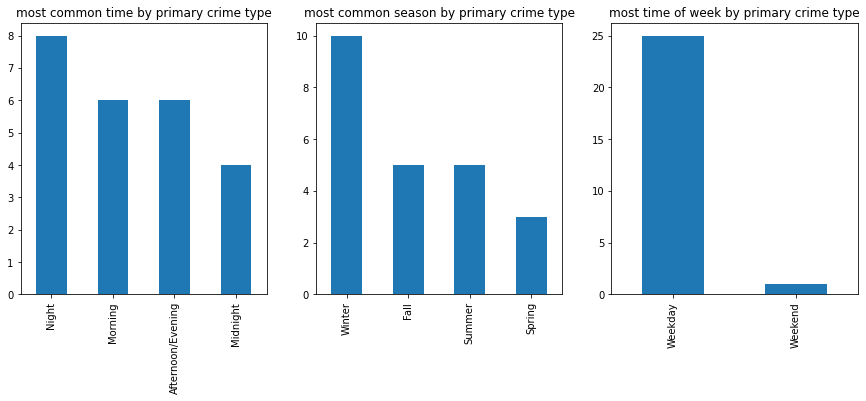

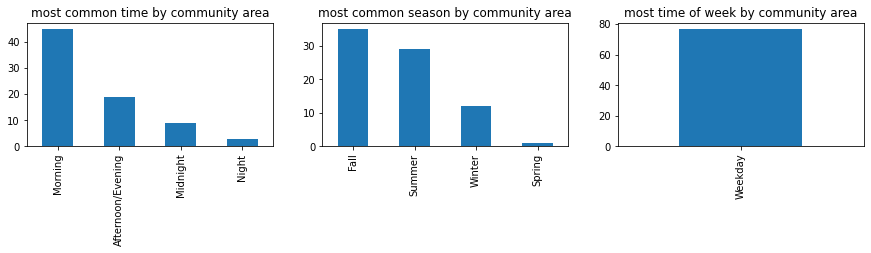

In [247]:
plt.subplot(1, 3, 1)
MostCommonCrimeTimeCounts = MostCommonCrimeTime['TimeOfDay'].value_counts()
MostCommonCrimeTimeCounts.plot(kind='bar', title = 'most common time by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 2)
MostCommonCrimeSeasonCounts = MostCommonCrimeSeason['Season'].value_counts()
MostCommonCrimeSeasonCounts.plot(kind='bar', title = 'most common season by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 3)
MostCommonCrimeWeekCounts = MostCommonCrimeWeek['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCounts.plot(kind='bar', title = 'most time of week by primary crime type', figsize=(15,5))
plt.show()

plt.subplot(2, 3, 1)
MostCommonCrimeTimeCountsCA = MostCommonCrimeTimeCA['TimeOfDay'].value_counts()
MostCommonCrimeTimeCountsCA.plot(kind='bar', title = 'most common time by community area', figsize=(15,5))

plt.subplot(2, 3, 2)
MostCommonCrimeSeasonCountsCA = MostCommonCrimeSeasonCA['Season'].value_counts()
MostCommonCrimeSeasonCountsCA.plot(kind='bar', title = 'most common season by community area', figsize=(15,5))

plt.subplot(2, 3, 3)
MostCommonCrimeWeekCountsCA = MostCommonCrimeWeekCA['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCountsCA.plot(kind='bar', title = 'most time of week by community area', figsize=(15,5))
plt.show()

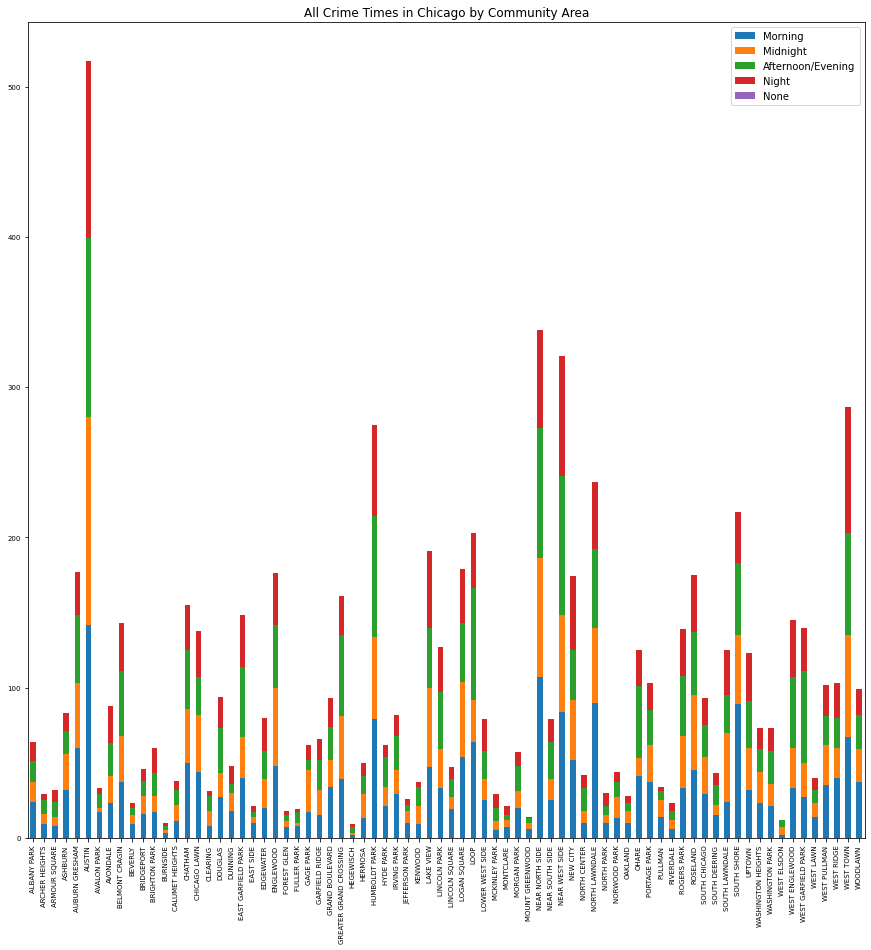

In [248]:
# For seeing all the times crimes are committed by community area
CrimeTimeCountsCA = pd.DataFrame()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

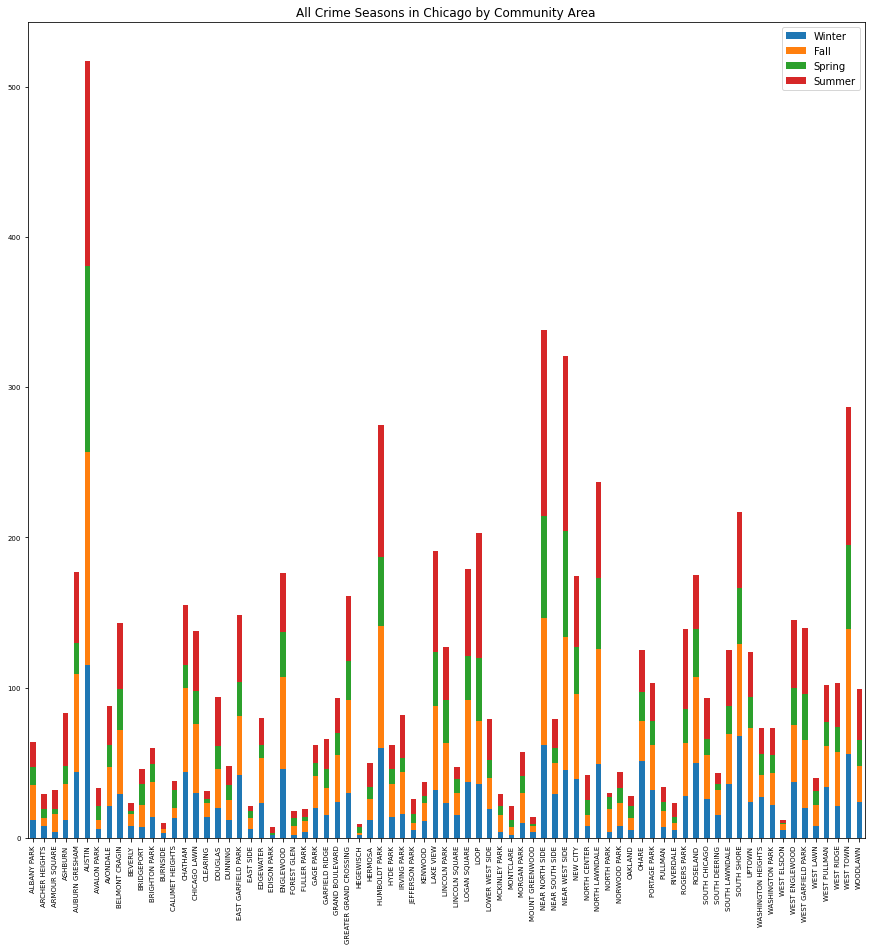

In [249]:
# For seeing all the seasons crimes are committed by community area
CrimeSeasonCountsCA = pd.DataFrame()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

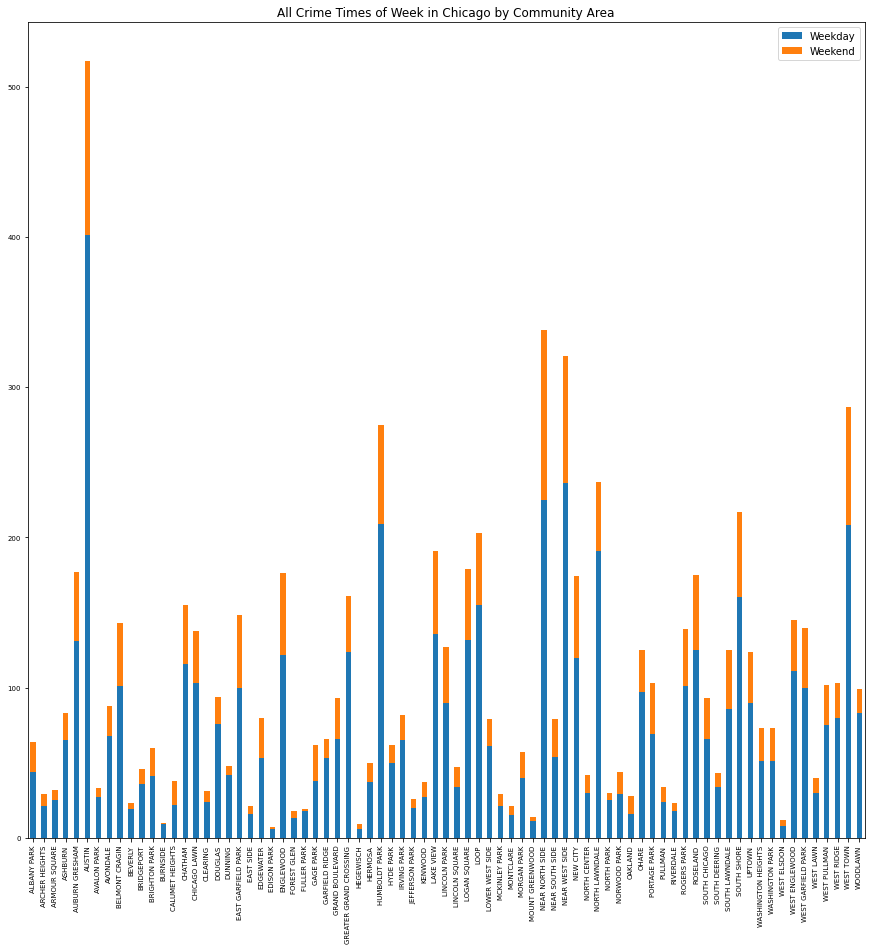

In [250]:
# For seeing all the time of week crimes are committed by community area
CrimeWeekCountsCA = pd.DataFrame()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

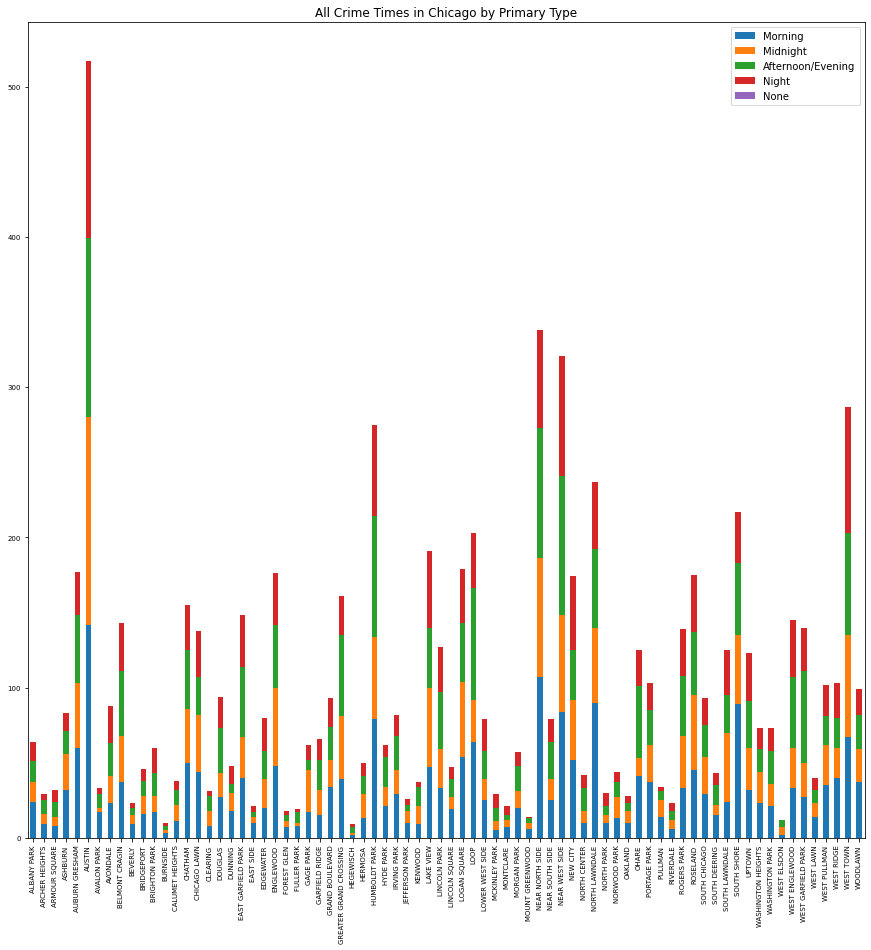

In [251]:
# For seeing all the times crimes are committed by primary type
CrimeTimeCounts = pd.DataFrame()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

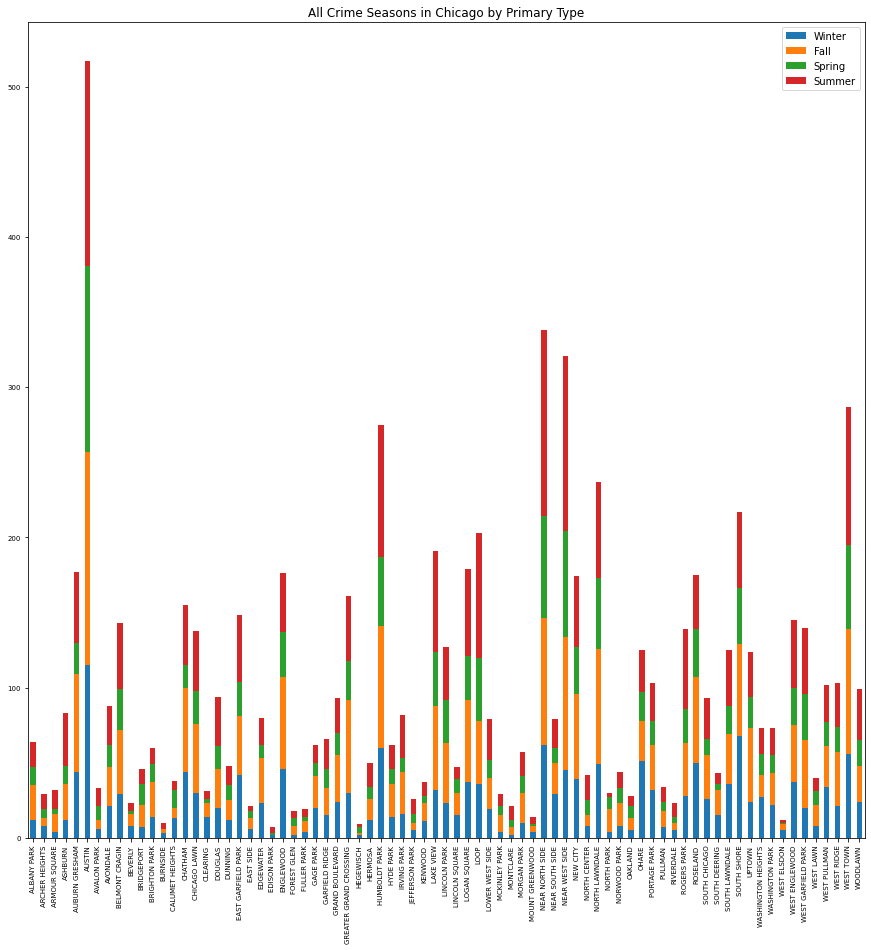

In [252]:
# For seeing all the seasons crimes are committed by primary type
CrimeSeasonCounts = pd.DataFrame()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

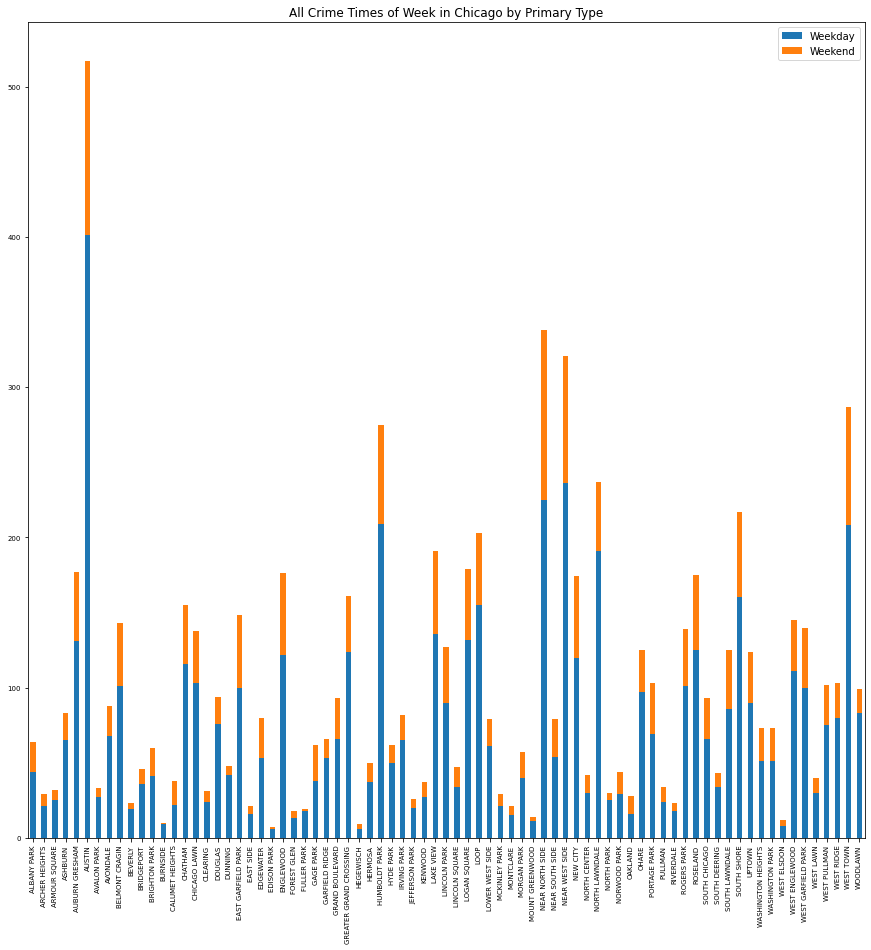

In [253]:
# For seeing all the time of week crimes are committed by primary type
CrimeWeekCounts = pd.DataFrame()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

# Dimensionality Reduction

In [254]:
# Converting from percentages
crimeDR = SampledSocioeconomicCrimeData.copy()

count = SampledCrimeData.groupby('Community_Name').count()
count = pd.DataFrame(count['ID'])
count.columns = ['crimes']
count = count.sort_index()

crimeDR = crimeDR[['Community_Name','percent_housing_crowded',
       'percent_households_below_poverty', 'percent_age16_unemployed',
       'percent_age25_nohighschool', 'hardship_index', 'Total Population',
       'Median Age','Vacant_Households', 'Male_Female_Ratio ']]

crimeDR[['percent_housing_crowded',
       'percent_households_below_poverty', 'percent_age16_unemployed',
       'percent_age25_nohighschool']] /= 100 

crimeDR['percent_housing_crowded'] *=  crimeDR['Total Population']
crimeDR['percent_households_below_poverty'] *=  crimeDR['Total Population']
crimeDR['percent_age16_unemployed'] *=  crimeDR['Total Population']
crimeDR['percent_age25_nohighschool'] *=  crimeDR['Total Population']

crimeDR.columns = ['Community_Name','num_housing_crowded',
       'num_households_below_poverty', 'num_age16_unemployed',
       'num_age25_nohighschool', 'hardship_index', 'Total Population',
       'Median Age','Vacant_Households', 'Male_Female_Ratio ']

community_areas = MostCommonPrimaryCrimeType.index.tolist()
crimeDR = crimeDR[crimeDR['Community_Name'].isin(community_areas)]
crimeDR = crimeDR.set_index('Community_Name')
crimeDR['num_crimes'] = count['crimes']
crimeDR = crimeDR.loc[~crimeDR.index.duplicated(keep='first')]

crimeDR.head()

pca = PCA(n_components=2)
pca.fit(crimeDR.values)

projected = pca.transform(crimeDR)
projected = pd.DataFrame(projected, columns=['pc1','pc2'], index=crimeDR.index)
projected.head()

,pc1,pc2
Community_Name,,
AVALON PARK,-27272.014243,-472.432995
WASHINGTON HEIGHTS,-10341.840122,-1478.161244
ASHBURN,4223.101123,-2749.738672
WOODLAWN,-12226.578665,529.279837
LOOP,-8528.768984,-5774.076568


Text(0.5, 1.0, '2nd PC')

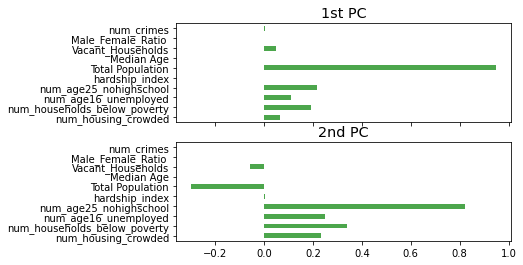

In [255]:
comp = pd.DataFrame(pca.components_, columns=crimeDR.columns, index=['pc1','pc2'])
fig, axes = plt.subplots(2,1,sharex=True)
comp.loc['pc1'].plot(kind='barh',ax=axes[0],color='g',alpha=0.7)
axes[0].set_title('1st PC', size='x-large')
comp.loc['pc2'].plot(kind='barh',ax=axes[1],color='g',alpha=0.7)
axes[1].set_title('2nd PC', size='x-large')

In [256]:
comp = pd.DataFrame(pca.components_, columns=crimeDR.columns, index=['pc1','pc2'])
comp

,num_housing_crowded,num_households_below_poverty,num_age16_unemployed,num_age25_nohighschool,hardship_index,Total Population,Median Age,Vacant_Households,Male_Female_Ratio,num_crimes
pc1,0.065953,0.192133,0.110498,0.215971,-0.000127,0.947344,-0.000057,0.049127,0.000002,0.002658
pc2,0.232289,0.339467,0.248035,0.822631,0.003517,-0.298424,-0.000257,-0.059087,0.000004,-0.000500


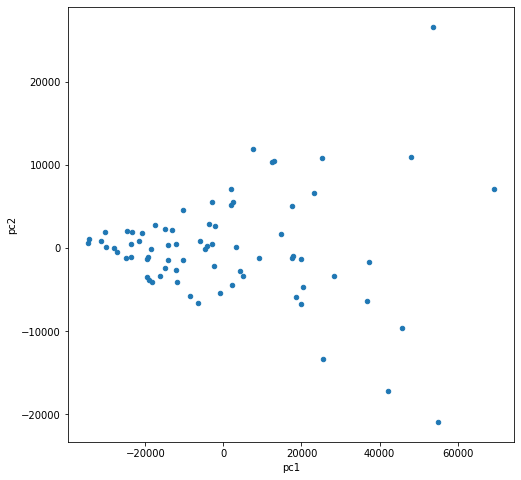

In [257]:
projected.plot(kind='scatter',x='pc1',y='pc2', figsize=(8,8))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

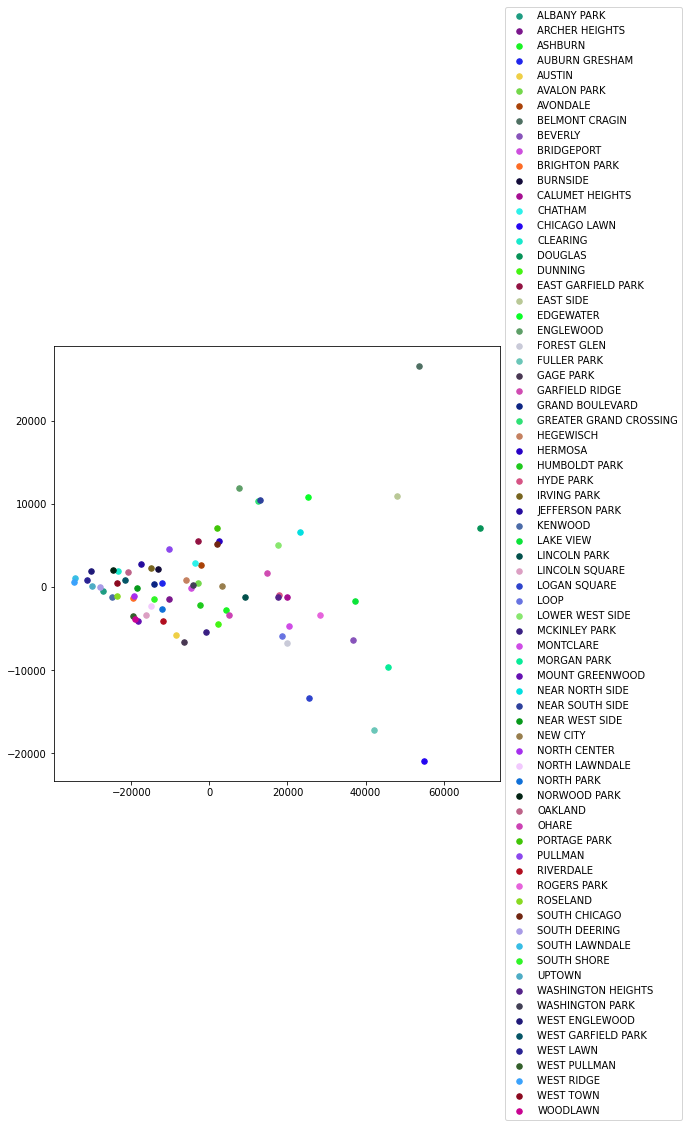

In [258]:
plt.figure(figsize=(8,8))
for index, row in projected.iterrows():
    plt.scatter(row['pc1'], row['pc2'], c = dictionary[index], s= 30)

legend = plt.legend(community_areas,prop={'size': 10}, loc='center left', bbox_to_anchor=(1, 0.5))
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
plt.show()

# Regression

In [259]:
# Our goal is to predict "num_crimes" (target attribute) based on the
# rest of the columns in the data frame
Y = crimeDR['num_crimes']
X = crimeDR.drop(columns=['num_crimes'])
X.head()

,num_housing_crowded,num_households_below_poverty,num_age16_unemployed,num_age25_nohighschool,hardship_index,Total Population,Median Age,Vacant_Households,Male_Female_Ratio
Community_Name,,,,,,,,,
AVALON PARK,142.590,1751.820,2149.035,1079.610,41.0,10185.0,42.9,371.0,0.769765
WASHINGTON HEIGHTS,291.423,4477.317,5510.544,3629.541,48.0,26493.0,41.2,883.0,0.788497
ASHBURN,1643.240,4272.424,4806.477,7271.337,37.0,41081.0,33.5,609.0,0.920481
WOODLAWN,688.460,7288.180,5555.160,3917.100,58.0,23740.0,31.4,2714.0,0.811799
LOOP,439.245,4304.601,1669.131,907.773,3.0,29283.0,30.5,5063.0,0.976044


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

Root mean squared error = 53.9348
R-square = 0.5255
Linear Regression Accuracy:  52.55 %
***************************
Slope Coefficients: [ 1.35485252e-02  3.67937402e-03  1.43398451e-02 -6.71080407e-03
 -2.95289348e-01 -1.39937438e-04 -1.66173049e+00  2.01332605e-02
 -5.26880310e+01]
Intercept: 107.33486807275764


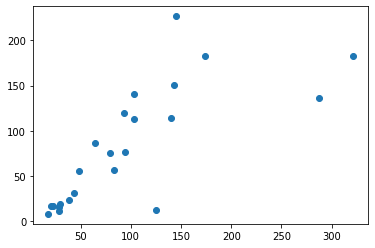

In [261]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Apply model to the test set
y_pred_test = regr.predict(X_test)
accuracy = regr.score(X_test,y_test)

print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))
print("Linear Regression Accuracy: ",round(accuracy*100,2),'%')
print("***************************")
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

plt.scatter(y_test,y_pred_test)

In [262]:

#RENAME STRINGS TO NUMBERS FOR LINEAR REGRESSION TO WORK

AggregatedDataframe.loc[AggregatedDataframe['Season'] == "Winter", 'Season'] = 1
AggregatedDataframe.loc[AggregatedDataframe['Season'] == "Spring", 'Season'] = 2
AggregatedDataframe.loc[AggregatedDataframe['Season'] == "Summer", 'Season'] = 3
AggregatedDataframe.loc[AggregatedDataframe['Season'] == "Fall", 'Season'] = 4

AggregatedDataframe.loc[AggregatedDataframe['TimeOfDay'] == "Morning", 'TimeOfDay'] = 1
AggregatedDataframe.loc[AggregatedDataframe['TimeOfDay'] == "Afternoon/Evening", 'TimeOfDay'] = 2
AggregatedDataframe.loc[AggregatedDataframe['TimeOfDay'] == "Night", 'TimeOfDay'] = 3
AggregatedDataframe.loc[AggregatedDataframe['TimeOfDay'] == "Midnight", 'TimeOfDay'] = 4

AggregatedDataframe.loc[AggregatedDataframe['Weekday_Weekend'] == "Weekday", 'Weekday_Weekend'] = 1
AggregatedDataframe.loc[AggregatedDataframe['Weekday_Weekend'] == "Weekend", 'Weekday_Weekend'] = 0

AggregatedDataframe = AggregatedDataframe.dropna()
# Our goal is to predict "num_crimes" (target attribute) based on the
# rest of the columns in the data frame
Y = AggregatedDataframe['Num_Crimes']
X = AggregatedDataframe.drop(columns=['Num_Crimes','Community_Name'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X.head()

,Community_Area,percent_age16_unemployed,percent_households_below_poverty,percent_age25_nohighschool,per_capita_income,hardship_index,Average_Household_Size,Vacant_Households,Num_Asian,Num_African_American,Num_White,TimeOfDay,Season,Weekday_Weekend
0,25.0,22.6,28.6,24.4,15957.0,73.0,2.96,5422.0,573.0,83837.0,4364.0,4,1,1
1,25.0,22.6,28.6,24.4,15957.0,73.0,2.96,5422.0,573.0,83837.0,4364.0,1,4,1
2,25.0,22.6,28.6,24.4,15957.0,73.0,2.96,5422.0,573.0,83837.0,4364.0,3,3,1
3,25.0,22.6,28.6,24.4,15957.0,73.0,2.96,5422.0,573.0,83837.0,4364.0,2,4,1
4,25.0,22.6,28.6,24.4,15957.0,73.0,2.96,5422.0,573.0,83837.0,4364.0,1,1,1


Root mean squared error = 3.1982
R-square = 0.4795
Linear Regression Accuracy:  47.952406325615364 %
***************************
Slope Coefficients: [-9.24531329e-03 -1.10513922e-02  1.00854765e-01  8.11046866e-02
  7.81524656e-06 -7.01367222e-02  1.08772300e+00  8.65425841e-04
 -2.65839163e-05  1.00624874e-04  1.30760457e-05 -3.18748985e-01
  4.46453093e-01  3.18261303e+00]
Intercept: -4.472072041894302


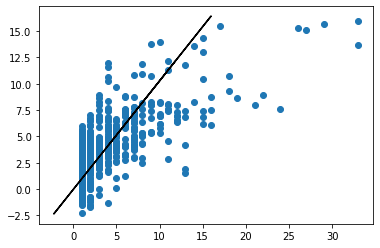

In [269]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Apply model to the test set
y_pred_test = regr.predict(X_test)
accuracy = regr.score(X_test,y_test)

print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))
print("Linear Regression Accuracy: ",accuracy*100,'%')
print("***************************")
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

m, b = np.polyfit(y_pred_test,y_test, 1)
plt.plot(y_pred_test, m*y_pred_test + b,color='black')
plt.scatter(y_test,y_pred_test)